## Denoising Dirty Documents
### By Muhammad Hanan Asghar

In [ ]:
!nvidia-smi

Sat Jun 11 03:27:13 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Collecting Dataset

In [ ]:
! pip install -q kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
!kaggle competitions download -c denoising-dirty-documents

 25% 9.00M/35.7M [00:00<00:01, 27.3MB/s]
100% 35.7M/35.7M [00:00<00:00, 89.7MB/s]


In [ ]:
!unzip *.zip && rm -rf 'denoising-dirty-documents.zip'

Archive:  denoising-dirty-documents.zip
  inflating: sampleSubmission.csv.zip  
  inflating: test.zip                
  inflating: train.zip               
  inflating: train_cleaned.zip       


In [ ]:
!unzip test.zip

In [ ]:
!unzip train.zip

In [ ]:
!unzip train_cleaned.zip

#Custom DataGenerator

#### Libraries

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import LeakyReLU

import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import os
import cv2

In [ ]:
images = []

train = [i.split(".")[0] for i in os.listdir("train")]
test = [i.split(".")[0] for i in os.listdir("train_cleaned")]

for i in train:
  if i in test:
    images.append(i+".png")

In [ ]:
class DenoisingGenerator(tf.keras.utils.Sequence):
    def __init__(self, datapath, x_seed, y_seed,
                 batch_size,
                 input_size=(128, 128, 3)):
        self.datapath = datapath.copy()
        self.batch_size = batch_size
        self.input_size = input_size
        self.x_path = x_seed
        self.y_path = y_seed
        
        self.n = len(self.datapath)
        self.m = 0
        self.max = self.__len__()
    
    def __len__(self):
        return int(len(self.datapath) / float(self.batch_size))
    
    def __get_image(self, path, target_size):
        image = tf.keras.preprocessing.image.load_img(path)
        image_arr = tf.keras.preprocessing.image.img_to_array(image)
        image_arr = tf.image.resize(image_arr,(target_size[0], target_size[1])).numpy()
        image_arr = image_arr.astype('float32') / 255.0
        return image_arr
    
    def __get_data(self, batches):
        # Generates data containing batch_size samples
        batch = np.asarray([self.__get_image(x, self.input_size) for x in batches])
        return batch


    def __getitem__(self, index):
        batches = self.datapath[index * self.batch_size:(index + 1) * self.batch_size]
        x_batches = [os.path.join(self.x_path, img) for img in batches]
        y_batches = [os.path.join(self.y_path, img) for img in batches]
        
        x = self.__get_data(x_batches)
        y = self.__get_data(y_batches)
        return x, y

    def __next__(self):
        if self.m >= self.max:
            self.m = 0
        _x, _y = self.__getitem__(self.m)
        self.m += 1
        return _x, _y

In [ ]:
generator = DenoisingGenerator(
    datapath=images,
    x_seed="/content/train",
    y_seed="/content/train_cleaned",
    batch_size=2,
    input_size=(512, 512, 3)
)

In [ ]:
x, y = next(generator)

In [ ]:
x.shape

(2, 512, 512, 3)

In [ ]:
y.shape

(2, 512, 512, 3)

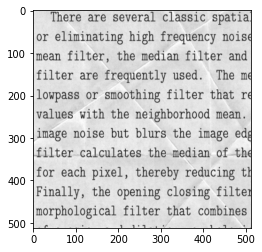

In [ ]:
plt.imshow(x[0].reshape((512, 512, 3)))

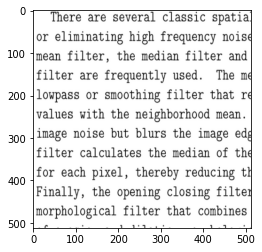

In [ ]:
plt.imshow(y[0].reshape((512, 512, 3)))

In [ ]:
# defining function to plot images pair
def plot_images(color,grayscale):
    plt.figure(figsize=(15,15))
    plt.subplot(1,3,1)
    plt.title('Noised Image', color = 'green', fontsize = 20)
    plt.imshow(color.reshape((512, 512, 3)))
    plt.subplot(1,3,2)
    plt.title('Denoised Image ', color = 'black', fontsize = 20)
    plt.imshow(grayscale.reshape((512, 512, 3)))
   
    plt.show()

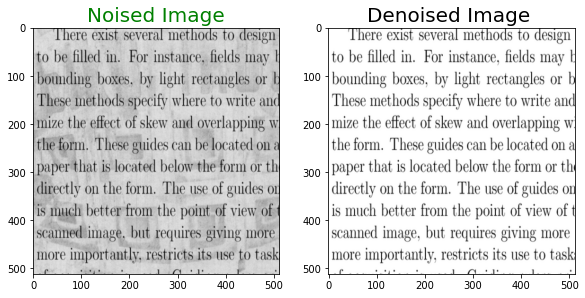

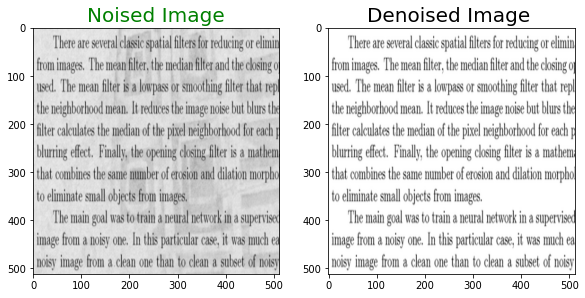

In [ ]:
x, y = next(generator)

for idx in range(2):
  plot_images(x[idx], y[idx])

## Model

In [ ]:
generator.__len__()

72

In [ ]:
momentum = 0.9
alpha = 0.2

# Encoder
model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(3, 3), padding="same", strides=2, input_shape=(512, 512, 3)))
model.add(LeakyReLU(alpha=alpha))
model.add(BatchNormalization(momentum=momentum))

model.add(Conv2D(filters=64, kernel_size=(3, 3), padding="same"))
model.add(LeakyReLU(alpha=alpha))
model.add(BatchNormalization(momentum=momentum))

model.add(Conv2D(filters=64, kernel_size=(3, 3), padding="same", strides=2))
model.add(LeakyReLU(alpha=alpha))
model.add(BatchNormalization(momentum=momentum))

model.add(Conv2D(filters=128, kernel_size=(3, 3), padding="same"))
model.add(LeakyReLU(alpha=alpha))
model.add(BatchNormalization(momentum=momentum))

model.add(Conv2D(filters=128, kernel_size=(3, 3), padding="same", strides=2))
model.add(LeakyReLU(alpha=alpha))
model.add(BatchNormalization(momentum=momentum))

model.add(Conv2D(filters=256, kernel_size=(3, 3), padding="same", strides=2))
model.add(LeakyReLU(alpha=alpha))
model.add(BatchNormalization(momentum=momentum))

model.add(Conv2D(filters=256, kernel_size=(3, 3), padding="same", strides=2))
model.add(LeakyReLU(alpha=alpha, name="Encoder_Output"))



# Decoder
model.add(Conv2DTranspose(filters=256, kernel_size=(3, 3), strides=2, padding="same"))
model.add(LeakyReLU(alpha=alpha))
model.add(BatchNormalization(momentum=momentum))

model.add(Conv2DTranspose(filters=256, kernel_size=(3, 3), strides=2, padding="same"))
model.add(LeakyReLU(alpha=alpha))
model.add(BatchNormalization(momentum=momentum))

model.add(Conv2DTranspose(filters=128, kernel_size=(3, 3), strides=2, padding="same"))
model.add(LeakyReLU(alpha=alpha))
model.add(BatchNormalization(momentum=momentum))

model.add(Conv2DTranspose(filters=64, kernel_size=(3, 3), strides=2, padding="same"))
model.add(LeakyReLU(alpha=alpha))
model.add(BatchNormalization(momentum=momentum))

model.add(Conv2DTranspose(filters=32, kernel_size=(3, 3), strides=2, padding="same"))
model.add(LeakyReLU(alpha=alpha))
model.add(BatchNormalization(momentum=momentum))

model.add(Conv2DTranspose(filters=3, kernel_size=(3, 3), strides=1, padding="same"))
model.add(Activation("tanh", name="Decoder_Output"))

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 256, 256, 32)      896       
                                                                 
 leaky_re_lu_11 (LeakyReLU)  (None, 256, 256, 32)      0         
                                                                 
 batch_normalization_11 (Bat  (None, 256, 256, 32)     128       
 chNormalization)                                                
                                                                 
 conv2d_8 (Conv2D)           (None, 256, 256, 64)      18496     
                                                                 
 leaky_re_lu_12 (LeakyReLU)  (None, 256, 256, 64)      0         
                                                                 
 batch_normalization_12 (Bat  (None, 256, 256, 64)     256       
 chNormalization)                                     

In [ ]:
opt = tf.keras.optimizers.Adam(learning_rate = 0.001)
model.compile(loss="mse", optimizer=opt, metrics=["accuracy"])

### Training

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint

callbacks = [
    ReduceLROnPlateau(verbose=1),
    ModelCheckpoint(
        'chkp/weights.{epoch:02d}-{accuracy:.2f}.hdf5',
        verbose=1),
]

In [ ]:
history = model.fit(
    generator,
    epochs=50,
    callbacks=callbacks)

Epoch 1/50
72/72 [==============================] - ETA: 0s - loss: 0.2560 - accuracy: 0.6957WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy,lr

Epoch 1: saving model to chkp/weights.01-0.70.hdf5
72/72 [==============================] - 8s 92ms/step - loss: 0.2560 - accuracy: 0.6957 - lr: 0.0010
Epoch 2/50
72/72 [==============================] - ETA: 0s - loss: 0.0860 - accuracy: 0.5984WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy,lr

Epoch 2: saving model to chkp/weights.02-0.60.hdf5
72/72 [==============================] - 7s 93ms/step - loss: 0.0860 - accuracy: 0.5984 - lr: 0.0010
Epoch 3/50
72/72 [==============================] - ETA: 0s - loss: 0.0560 - accuracy: 0.6151WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: los

In [ ]:
# defining function to plot images pair
def plot_images(noised, denoised):
    plt.figure(figsize=(15,15))
    plt.subplot(1,3,1)
    plt.title('Noised Image', color = 'green', fontsize = 20)
    plt.imshow(noised)
    plt.subplot(1,3,2)
    plt.title('Denoised Image ', color = 'black', fontsize = 20)
    plt.imshow(denoised)
   
    plt.show()

In [ ]:
def load_image(path):
  image = tf.keras.preprocessing.image.load_img(path)
  image_arr = tf.keras.preprocessing.image.img_to_array(image)
  image_arr = tf.image.resize(image_arr,(512, 512)).numpy()
  image_arr = image_arr.astype('float32') / 255.0
  image_arr = tf.expand_dims(image_arr, 0)
  return image, image_arr

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


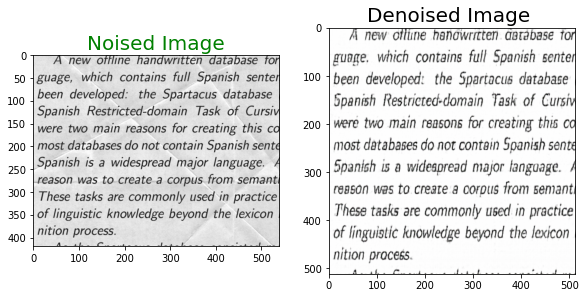

In [ ]:
image, image_arr = load_image("test/100.png")
y = model.predict(image_arr)

plot_images(image, y.reshape((512, 512, 3)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


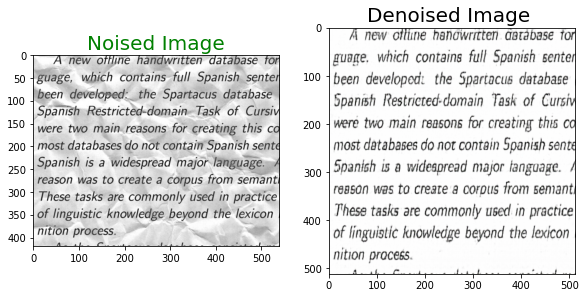

In [ ]:
image, image_arr = load_image("test/106.png")
y = model.predict(image_arr)

plot_images(image, y.reshape((512, 512, 3)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


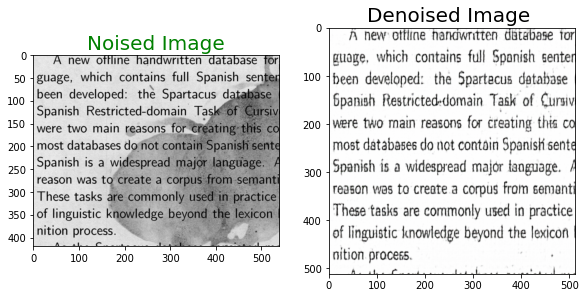

In [ ]:
image, image_arr = load_image("test/109.png")
y = model.predict(image_arr)

plot_images(image, y.reshape((512, 512, 3)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


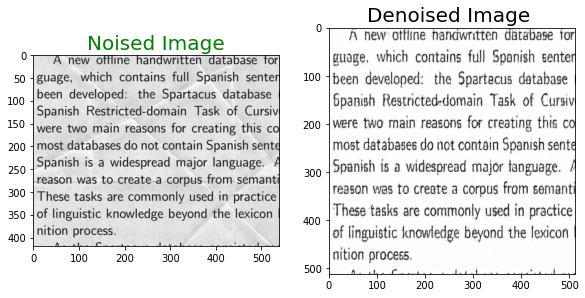

In [ ]:
image, image_arr = load_image("test/112.png")
y = model.predict(image_arr)

plot_images(image, y.reshape((512, 512, 3)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


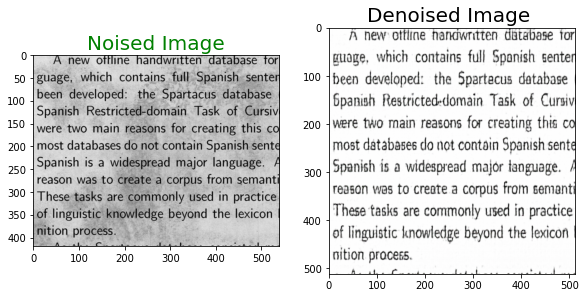

In [ ]:
image, image_arr = load_image("test/115.png")
y = model.predict(image_arr)

plot_images(image, y.reshape((512, 512, 3)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


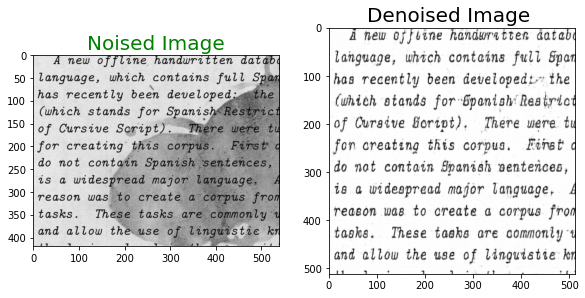

In [ ]:
image, image_arr = load_image("test/121.png")
y = model.predict(image_arr)

plot_images(image, y.reshape((512, 512, 3)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


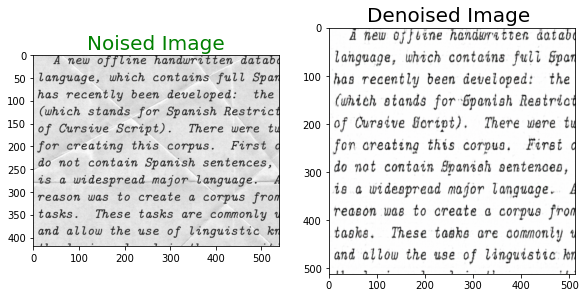

In [ ]:
image, image_arr = load_image("test/124.png")
y = model.predict(image_arr)

plot_images(image, y.reshape((512, 512, 3)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


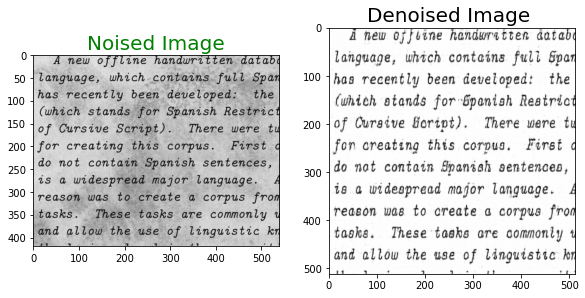

In [ ]:
image, image_arr = load_image("test/127.png")
y = model.predict(image_arr)

plot_images(image, y.reshape((512, 512, 3)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


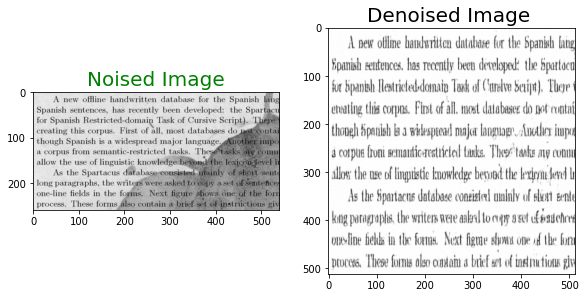

In [ ]:
image, image_arr = load_image("test/13.png")
y = model.predict(image_arr)

plot_images(image, y.reshape((512, 512, 3)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


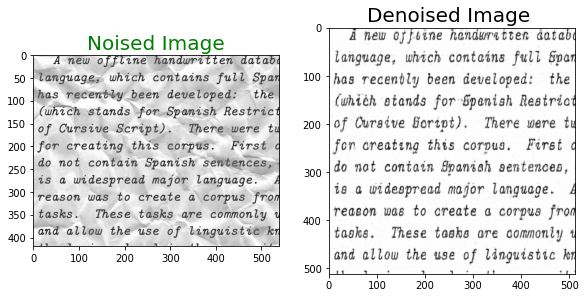

In [ ]:
image, image_arr = load_image("test/130.png")
y = model.predict(image_arr)

plot_images(image, y.reshape((512, 512, 3)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


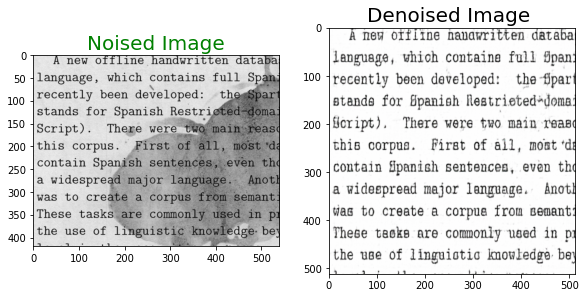

In [ ]:
image, image_arr = load_image("test/133.png")
y = model.predict(image_arr)

plot_images(image, y.reshape((512, 512, 3)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


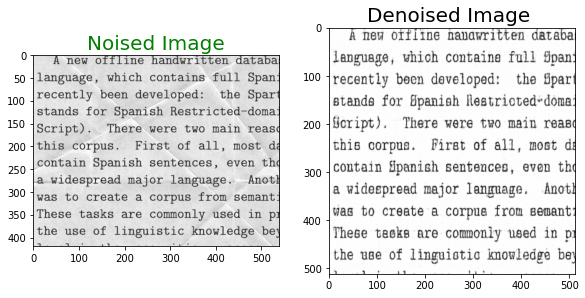

In [ ]:
image, image_arr = load_image("test/136.png")
y = model.predict(image_arr)

plot_images(image, y.reshape((512, 512, 3)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


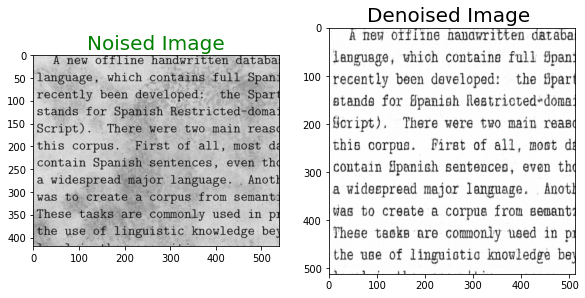

In [ ]:
image, image_arr = load_image("test/139.png")
y = model.predict(image_arr)

plot_images(image, y.reshape((512, 512, 3)))

#### Im